HC05 to computer bluetooth
---------------------------

I've been able to connect to the Arduino's HC-05 from my computer (which has a bluetooth chip) using the pybluez library (https://github.com/karulis/pybluez). 

I found it difficult to install pybluez via pip (Windows 10, python 3.5). If you have the same issue, try downloading the relevant .whl file from http://www.lfd.uci.edu/~gohlke/pythonlibs/#pybluez.


**Connect to HC-05 device**

In [1]:
import bluetooth

# Search for all nearby devices (HC-05 chips have a reliable range of about 10 metres)
nearby_devices = bluetooth.discover_devices(flush_cache=True)

hc05s = []
for device in nearby_devices:
    if bluetooth.lookup_name(device) == 'HC-05':
        hc05s.append(device)
        
        
# If we found no HC-05s....
if len(hc05s) == 0:
    # Oops. Check it's plugged in? If it's searching for connections, the onboard LED should be flashing rapidly.
    # also, if the name has been changed in AT mode, this won't work.
    raise IOError("No HC-05 found!")   
    
# If we found too many HC-05s...
elif len(hc05s) > 1:
    warnings.warn('Multiple HC-05s found - using the first')
    
else:
    addr = str(hc05s[0])
    ser = bluetooth.BluetoothSocket(bluetooth.RFCOMM)
    ser.connect((addr,1))
    ser.settimeout(10.0)
    print('Successfully connected to HC-05 at ' + addr)
     

Successfully connected to HC-05 at 98:D3:32:30:7D:5A


In [74]:
#data = "L"
#ser.send(data)
#ser.close()

1

**Playing with LDRs**

Plot a dynamically updating graph of LDR readings.

This code requires that you setup your Arduino with the HC-05 chip, and that you connect a LDR as shown below. You will need to upload the code 'LDR_bluetooth.ino' to your Arduino as well.

<img src="circuit.png">
circuit diagram taken from http://bildr.org/2012/11/photoresistor-arduino/

<IPython.core.display.Javascript object>


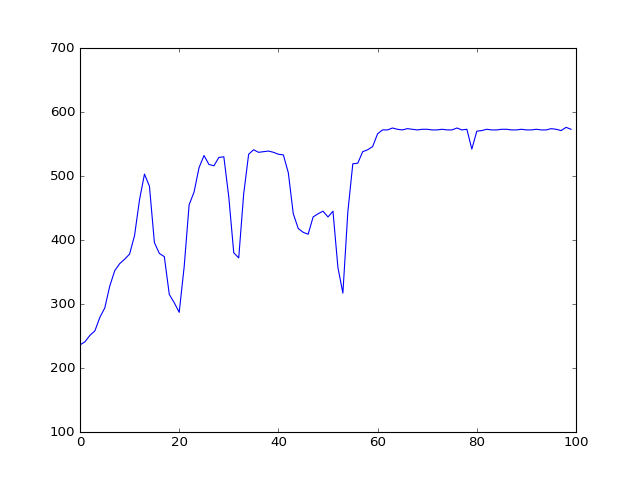

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from collections import deque

x = range(100)
y = deque([])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([0,100])
ax.set_ylim([100,700])
ax.set_ylabel('LDR value')
plt.ion()
fig.show()
fig.canvas.draw()

    
data = b""
while True:
    try:
        # Grab some data
        data += ser.recv(4096)
        results = re.findall('<(\d+)>\r\n', data.decode())
        data = re.sub('<\d+>\r\n', '', data.decode()).encode()
        
        for result in results:
            y.append(int(result))
            # We only want the last 100 items
            if len(y) > 100:
                y.popleft()
                
        ax.clear()

        ax.plot(x[0:len(y)], y)
        ax.set_xlim([0,100])
        ax.set_ylim([100,700])
        ax.set_ylabel('LDR value')
        fig.canvas.draw()
        time.sleep(0.1)
    
    except KeyboardInterrupt:
        break
    